In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import multivariate_normal
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import pearsonr
import random

## Извлечение данных и предварительная обработка

In [2]:
def extract_data(file_name):
    data_text = open(file_name, 'r')
    data_list = []
    event_counter = 0
    for line in data_text:
        line_data = list(map(float, line.split()))
        line_data = line_data[0:2]
        data_list.append(line_data)
        event_counter += 1
    first_event_time = data_list[0][0]
    last_event_time = data_list[-1][0]
    normolized_events = np.linspace(first_event_time,
                                    last_event_time, event_counter)
    for i in range(0, event_counter):
        data_list[i][0] = normolized_events[i]

    return data_list

In [3]:
data = extract_data('wnaap.dat')

In [4]:
def add_graph_parametrs(fig_size_x = 15, figsize_y = 15, #размеры окна с графиком
                    left_border = 1900, right_border = 2016, #границы, в которых показывается график по оси абсцисс
                    lower_border = -30, upper_border = 30 #границы, в которых показывается график по оси ординат
                   ):
    plt.figure(figsize=(fig_size_x, figsize_y))
    axes = plt.gca()
    axes.set_xlim([left_border, right_border])
    axes.set_ylim([lower_border, upper_border])
    plt.grid()
    plt.xlabel('time')
    plt.ylabel(r'$B_\phi$', rotation='horizontal')

In [5]:
month = 1 / 12
activity_minimums_list = [1902 + 1 * month,
                          1913 + 7 * month,
                          1923 + 7 * month,
                          1933 + 8 * month,
                          1944 + 1 * month,
                          1954 + 3 * month,
                          1964 + 9 * month,
                          1976 + 5 * month,
                          1986 + 8 * month,
                          1996 + 4 * month,
                          2009 + 0 * month]

In [6]:
def get_changed_data(data, minimums):
    i = 0
    j = 0
    event_num = len(data)
    minimums_num = len(minimums)
    changed_data = []
    sign = -1
    while (i < event_num):
        while (i < event_num and
               (j >= minimums_num or data[i][0] < minimums[j])):
            data_pair = [data[i][0], sign * np.sqrt(data[i][1])]
            changed_data.append(data_pair)
            i += 1
        j += 1
        sign *= -1 
    return changed_data

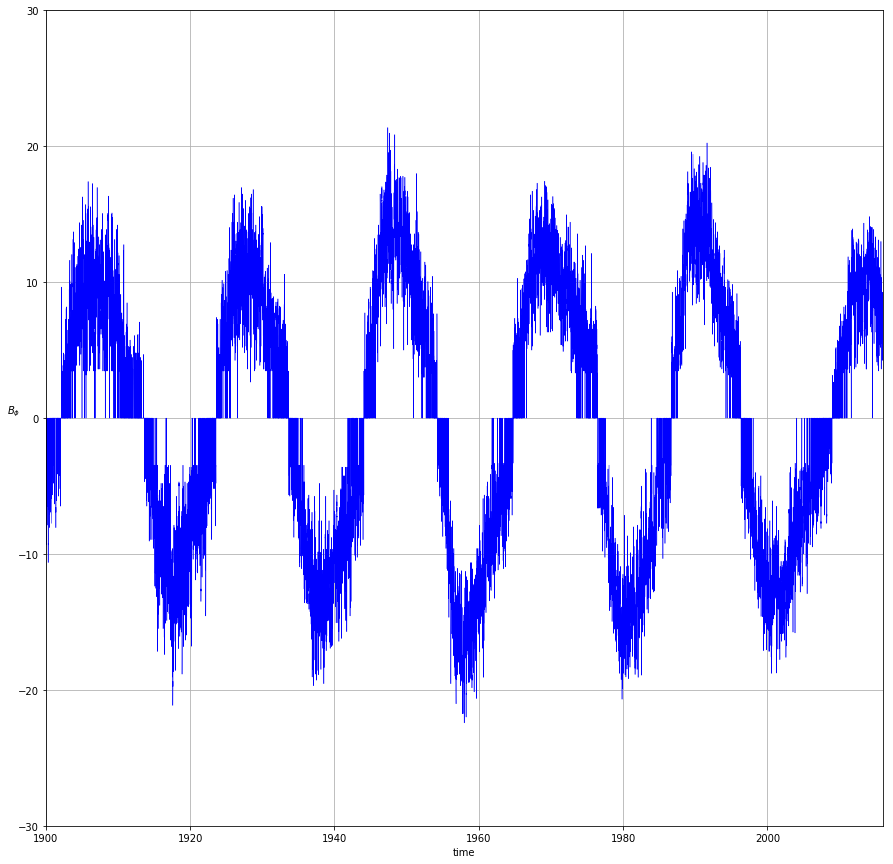

In [7]:
new_data = np.array(get_changed_data(data, activity_minimums_list))
add_graph_parametrs()
plt.plot(new_data[:,0], new_data[:,1], linewidth=0.5, color='b')
plt.show()

In [8]:
def FFT_low_pass(signal, fc, b):
    
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    s = list(signal[:,1])
    new_signal_data = np.convolve(s, sinc_func, mode='same')
    new_signal = []
    dots_num = len(s)
    for i in range(0, dots_num):
        append_data = [signal[i][0], new_signal_data[i]]
        new_signal.append(append_data)
    return new_signal

In [9]:
smoothed_data = np.array(FFT_low_pass(new_data, 0.0001, 0.0021))

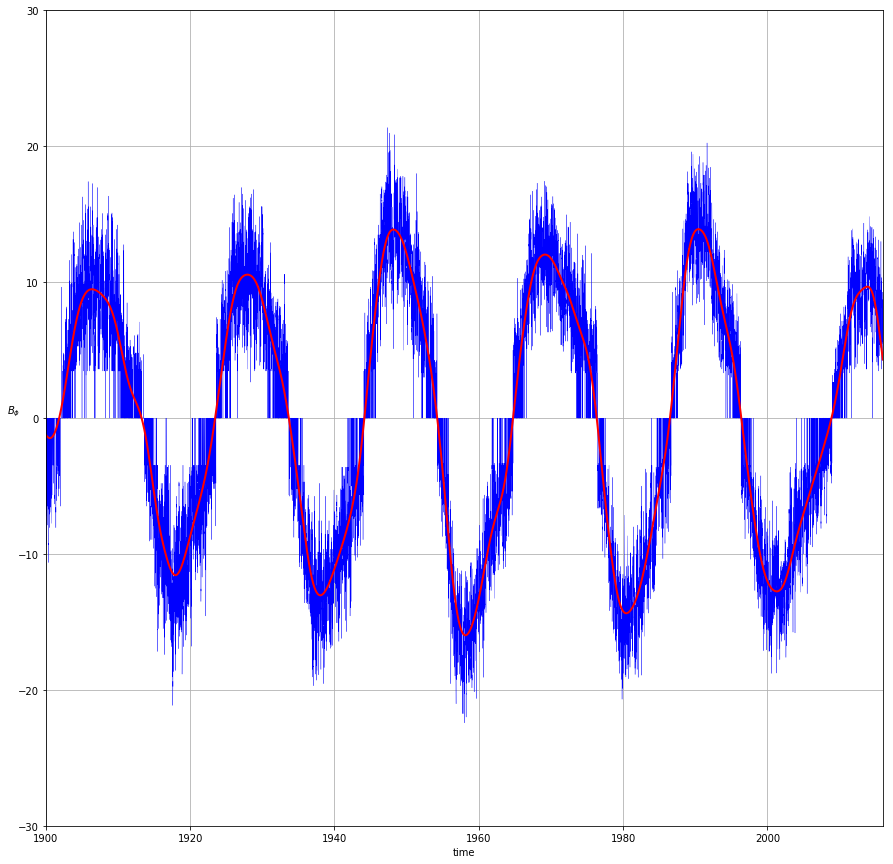

In [10]:
add_graph_parametrs()
plt.plot(new_data[:,0], new_data[:,1], linewidth=0.3, color='b')
plt.plot(smoothed_data[:,0], smoothed_data[:,1], linewidth=2, color='r')
plt.show()

## Получение циклов, фазовых портретов и их запись


In [11]:
def find_last_zero(data):
    i = np.shape(data)[0] - 1
    while (data[i, 1] > 0):
        i -= 1
    return i

In [12]:
def find_first_zero(data):
    i = 0
    while (data[i, 1] < 0):
        i += 1
    return i

In [13]:
def get_cycles_borders(data):
    borders = []
    start = find_first_zero(data)
    finish = find_last_zero(data)
    i = start
    while (i <= finish):
        while (i <= finish and (data[i, 1] * data[i + 1, 1] > 0)):
            i += 1
        cycle_borders = [start, i]
        start = i + 1
        borders.append(cycle_borders)
        i += 1
    return borders

In [14]:
def get_derivative (data, index):
    interval = np.array(data[index - 5: index + 5])
    k = np.polyfit(interval[:,0], interval[:, 1], 1)
    return k[0]

In [15]:
cycles = get_cycles_borders(smoothed_data)

In [16]:
def cycle_phase_portrait(start, finish, data):
    portrait = []
    for i in range(start, finish + 1):
        x = get_derivative(data, i)
        append_pair = [data[i][1], x]
        portrait.append(append_pair)
    return portrait

In [17]:
portraits = []
for cycle in cycles:
    portraits.append(np.array(cycle_phase_portrait(cycle[0], cycle[1], smoothed_data)))

In [18]:
def toFixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"

def write_cycles(portraits, cycles, file_name):
    f = open(file_name, 'w')
    cycles_num = len(portraits)
    for i in range(0, cycles_num):
        f.write(toFixed(data[cycles[i][0]][0], 12) + ' ' + toFixed(data[cycles[i][1]][0], 12) +
                ' ' + str(len(portraits[i])) + '\n')
        for j in range(0, len(portraits[i])):
            f.write(toFixed(portraits[i][j, 0], 12) + ' ' + toFixed(portraits[i][j, 1], 12) + '\n')

In [19]:
write_cycles(portraits, cycles, "/home/viacheslav/progs/Sun2.0/integral_no_prob_approx/approxible_data.txt")
write_cycles(portraits, cycles, "/home/viacheslav/progs/Sun2.0/distance_no_prob_approx/approxible_data.txt")

## Функции рисования

In [20]:
def draw_cycles(portraits, number, ax, col='r', label=None):
    if (number < 0 or number >= len(portraits)):
        picture = np.concatenate(portraits, axis = 0)
        ax.plot(picture[:,0], picture[:,1], linewidth=0.5, color = col, label = label)
    else:
        ax.plot(portraits[number][:,0], portraits[number][:,1], linewidth=0.5, color = col, label=label)

In [21]:
def draw_portraits(portraits, with_extra_portraits=False, with_parameters=False, extra_portraits=None, parameters=None):
    plt.figure(figsize=(16, 12))
    plt.subplots_adjust(hspace=0.5)
    for i in range(10):
        ax = plt.subplot(4, 3, i + 1)
        ax.set_title("cycle " + str(i + 1))
        ax.grid()
        ax.set_xlim([-17, 17])
        ax.set_ylim([-7, 7])
        ax.set_xlabel(r"$B_{\phi}$")
        ax.set_ylabel(r"$\frac{dB_{\phi}}{dt}$", rotation="horizontal")
        draw_cycles(portraits, i, ax, 'red')
        if (with_parameters):
            pos_x = ''
            x = 0.0
            if (i % 2):
                pos_x = 'right'
                x = 17 - 0.5
            else:
                pos_x = 'left'
                x = -17 + 0.5
            omega_str = r'$\omega_0 = $' + toFixed(parameters[i][1], 12) + "\n"
            epsilon_str = r'$\epsilon = $' + toFixed(parameters[i][2], 12) + "\n"
            lambda_str = r'$\lambda = $' + toFixed(parameters[i][3], 12) + "\n"
            mu_str = r'$\mu = $' + toFixed(parameters[i][4], 12) + "\n"
            mistake_str = 'mistake = ' + toFixed(parameters[i][0], 12)
            ax.text(x, -7 + 0.5, omega_str + epsilon_str + lambda_str + mu_str + mistake_str, ha = pos_x, va = 'bottom')
        if (with_extra_portraits):
            draw_cycles(extra_portraits, i, ax, 'blue')
    plt.show()

### циклы

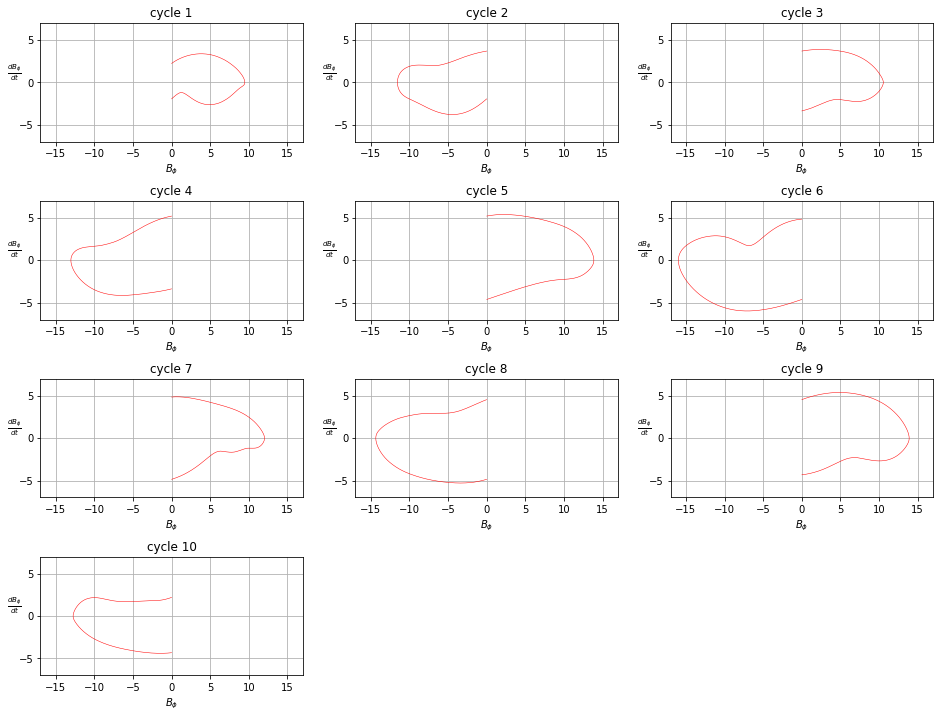

In [22]:
draw_portraits(portraits)

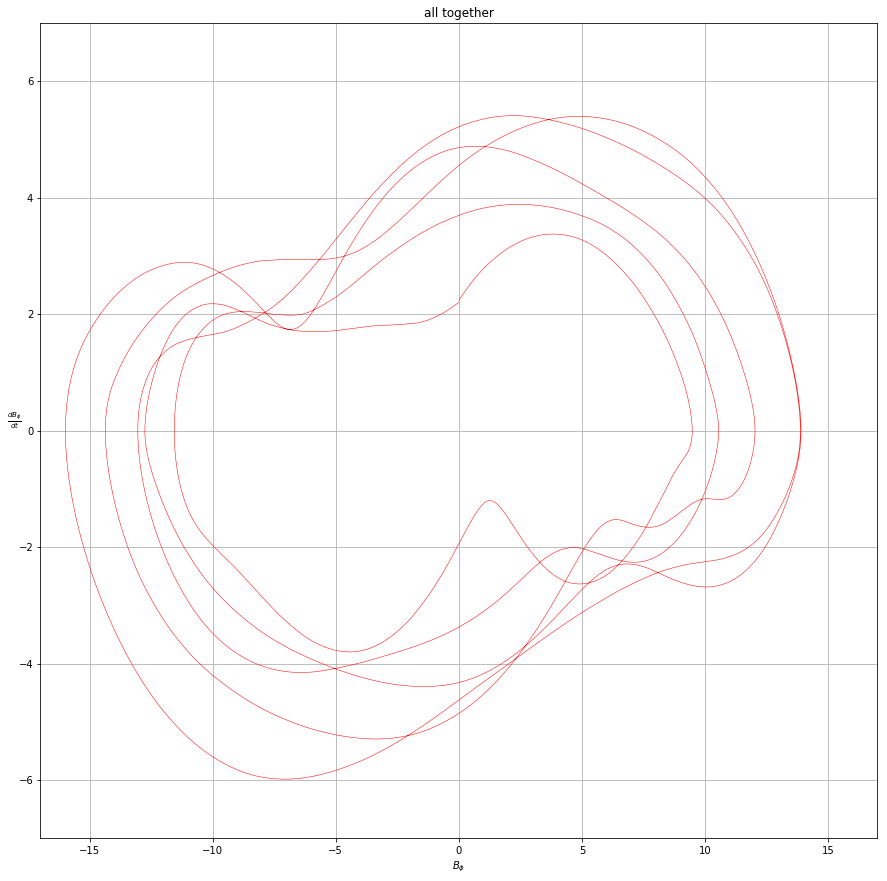

In [23]:
add_graph_parametrs(fig_size_x = 15, figsize_y = 15, 
                    left_border = -17, right_border = 17,
                    lower_border = -7, upper_border = 7)
plt.title("all together")
plt.xlabel(r"$B_{\phi}$")
plt.ylabel(r"$\frac{dB_{\phi}}{dt}$", rotation="horizontal")
draw_cycles(portraits, -1, plt)

## Функции для извлечения данных и их презентации


In [50]:
def extract_cycle(file_name):
    cycle_data = open(file_name, "r")
    dots_list = []
    for line in cycle_data:
        dot = list(map(float, line.split()))
        dots_list.append(dot)
    return np.array(dots_list)

In [24]:
def parameters_table(file_name):
    param_data = open(file_name, "r")
    param_list = []
    for line in param_data:
        line_data = list(map(float, line.split()))
        param_list.append(line_data)
    return np.array(param_list)

In [25]:
def extract_portraits(dir_name):
    portraits = []
    for i in range(10):
        portrait = extract_cycle(dir_name + "/cycle_" + str(i + 1) + ".txt")
        portraits.append(portrait)
    return portraits

In [26]:
def total_show(dir_name, smoothed_data, portraits):
    approx_portraits = extract_portraits(dir_name)
    p_and_m = parameters_table(dir_name + '/p&m.txt')
    draw_portraits(portraits, with_extra_portraits=True,
                   with_parameters=True, extra_portraits=approx_portraits, parameters=p_and_m)
    add_graph_parametrs(fig_size_x = 15, figsize_y = 15, 
                    left_border = -17, right_border = 17,
                    lower_border = -7, upper_border = 7)
    plt.title("all together")
    plt.xlabel(r"$B_{\phi}$")
    plt.ylabel(r"$\frac{dB_{\phi}}{dt}$", rotation="horizontal")
    draw_cycles(portraits, -1, plt, col='red', label='исходные данные')
    draw_cycles(approx_portraits, -1, plt, col='b',label='приближение')
    plt.legend()
    plt.show()
    general_with_time = extract_cycle(dir_name + "/general_sol.txt")
    add_graph_parametrs(fig_size_x = 15, figsize_y = 15,
                    left_border = smoothed_data[cycles[0][0], 0], right_border = smoothed_data[cycles[-1][1], 0],
                    lower_border = -30, upper_border = 30)
    plt.title("activity from time")
    data_slice = smoothed_data[cycles[0][0] : cycles[-1][1], : :]
    plt.plot(data_slice[:,0], data_slice[:,1], linewidth=2, color='r', label='исходные данные')
    plt.plot(general_with_time[:,0], general_with_time[:,1], linewidth=2, color='b', label='приближение')
    plt.show()
    return p_and_m

## Получение сглаживания вероятностным методом

In [27]:
def get_changed_data_2(data, minimums):
    i = 0
    j = 0
    event_num = len(data)
    minimums_num = len(minimums)
    changed_data = []
    while (i < event_num):
        while (i < event_num and
               (j >= minimums_num or data[i][0] < minimums[j])):
            data_pair = [data[i][0], np.sqrt(data[i][1])]
            changed_data.append(data_pair)
            i += 1
        j += 1
    return changed_data

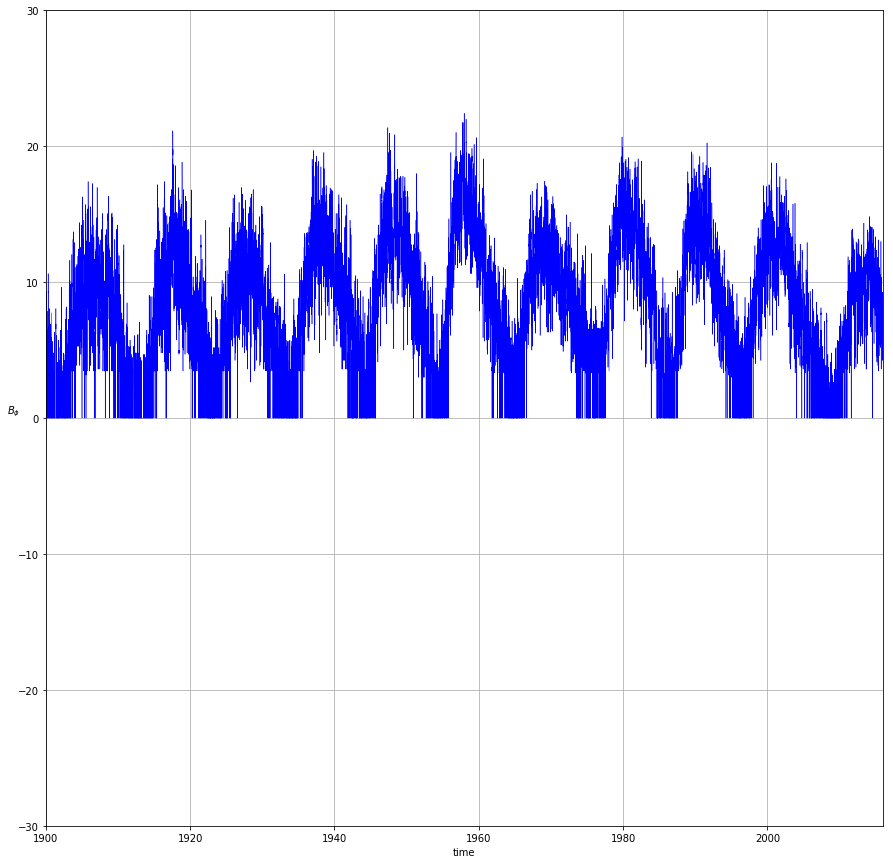

In [28]:
new_data_2 = np.array(get_changed_data_2(data, activity_minimums_list))
add_graph_parametrs()
plt.plot(new_data_2[:,0], new_data_2[:,1], linewidth=0.5, color='b')
plt.show()

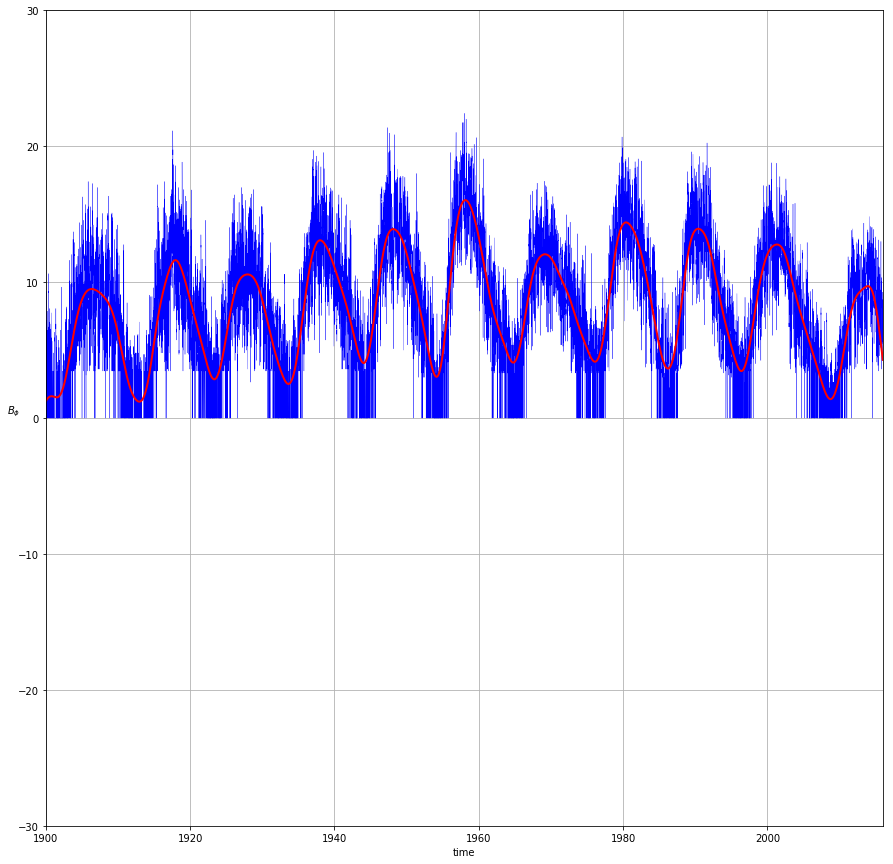

In [29]:
raw_smoothed_data_2 = np.array(FFT_low_pass(new_data_2, 0.0001, 0.0022))
add_graph_parametrs()
plt.plot(new_data_2[:,0], new_data_2[:,1], linewidth=0.3, color='b')
plt.plot(raw_smoothed_data_2[:,0], raw_smoothed_data_2[:,1], linewidth=2, color='r')
plt.show()

In [30]:
def find_minimums(data):
    minimums = []
    for i in range(1, len(data) - 1):
        if (data[i - 1, 1] > data[i, 1] and data[i, 1] < data[i + 1, 1]):
            minimums.append(i)
    return minimums

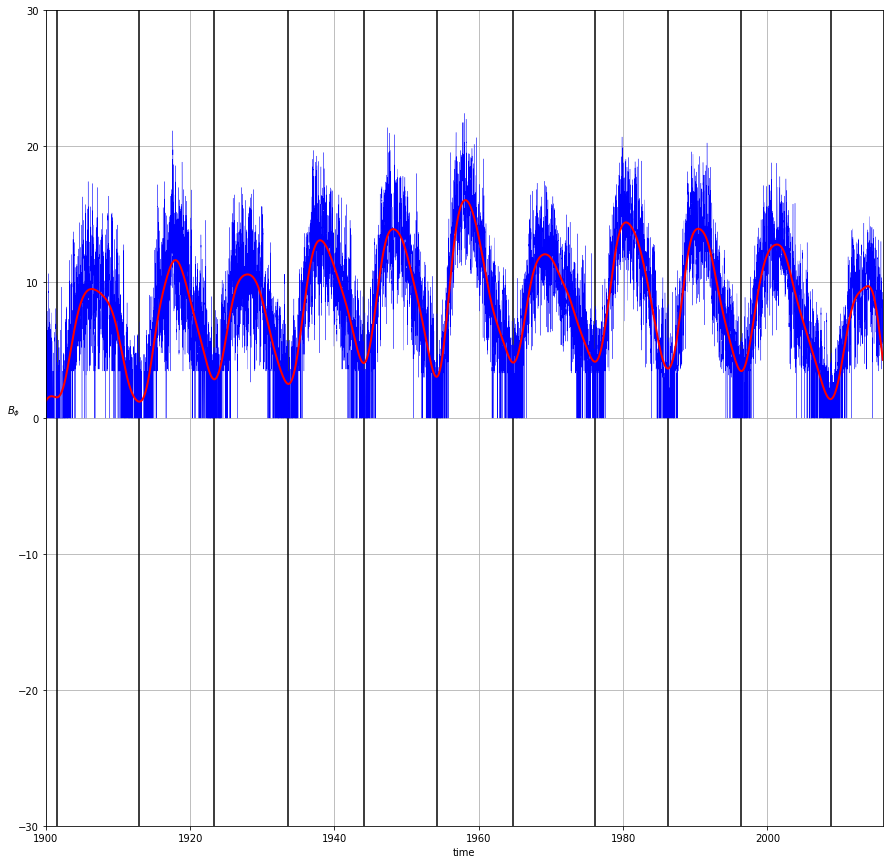

In [31]:
add_graph_parametrs()
minimums = find_minimums(raw_smoothed_data_2);
for i in minimums:
    plt.plot([raw_smoothed_data_2[i, 0], raw_smoothed_data_2[i, 0]], [-30, 30], color='black')
plt.plot(new_data_2[:,0], new_data_2[:,1], linewidth=0.3, color='b')
plt.plot(raw_smoothed_data_2[:,0], raw_smoothed_data_2[:,1], linewidth=2, color='r')
plt.show()

In [32]:
def get_ranges(data, minimums):
    i = 0
    j = 0
    events_num = len(data)
    min_num = len(minimums)
    flag_first = 0
    ranges = []
    append_pair = []
    while (i < events_num and j < min_num):
        if (not flag_first and abs(data[i, 0] - data[minimums[j], 0]) <= 0.75):
            flag_first = 1
            append_pair.append(i)
        if (flag_first and abs(data[i, 0] - data[minimums[j], 0]) > 0.75):
            flag_first = 0
            append_pair.append(i - 1)
            ranges.append(append_pair)
            append_pair = []
            j += 1
        i += 1
    return ranges

In [33]:
def get_signs(data, minimums, ranges):
    signs = []
    i = 0
    j = 0
    events_num = len(data)
    min_num = len(minimums)
    cur_sign = -1
    while (i < events_num):
        if (j < min_num and i == ranges[j][0]):
            a = data[minimums[j],:]
            sig = np.array([[0.75 ** 2, 0],
                           [0, (data[ranges[j][0], 1] + data[ranges[j][1], 1]) ** 2 / 4]])
            while (i <= minimums[j]):
                prob = 4 * multivariate_normal.cdf([data[i, 0],
                                                    2 * data[minimums[j], 1] - data[i, 1]],
                                                    mean=a, cov=sig)
                if (prob >= random.random()):
                    signs.append(-cur_sign)
                else:
                    signs.append(cur_sign)
                i += 1
            cur_sign = -cur_sign
            while (i <= ranges[j][1]):
                prob = 4 * multivariate_normal.cdf([2 * data[minimums[j], 0] - data[i, 0], 
                                                    2 * data[minimums[j], 1] - data[i, 1]],
                                                    mean=a, cov=sig)
                if (prob >= random.random()):
                    signs.append(-cur_sign)
                else:
                    signs.append(cur_sign)
                i += 1
            j += 1
        else:
            signs.append(cur_sign)
            i += 1
    return signs

In [34]:
ranges = get_ranges(raw_smoothed_data_2, minimums)

In [35]:
singns = get_signs(raw_smoothed_data_2, minimums, ranges)

In [36]:
def signed_data(data, signs):
    events_num = len(data)
    changed_data = []
    for i in range (0, events_num):
        changed_data.append([data[i, 0], data[i, 1] * signs[i]])
    return np.array(changed_data)

In [37]:
changed_data_2 = signed_data(new_data_2, singns)

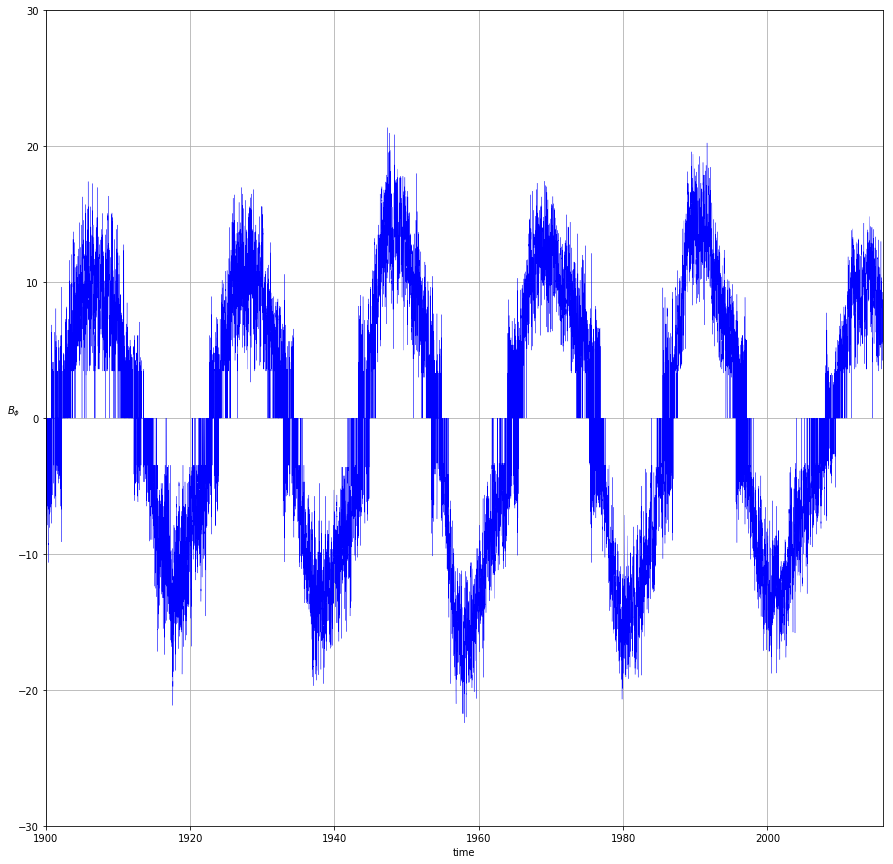

In [38]:
add_graph_parametrs()
plt.plot(changed_data_2[:,0], changed_data_2[:,1], linewidth=0.3, color='b')
plt.show()

In [39]:
smoothed_data_2 = np.array(FFT_low_pass(changed_data_2, 0.0001, 0.0022))

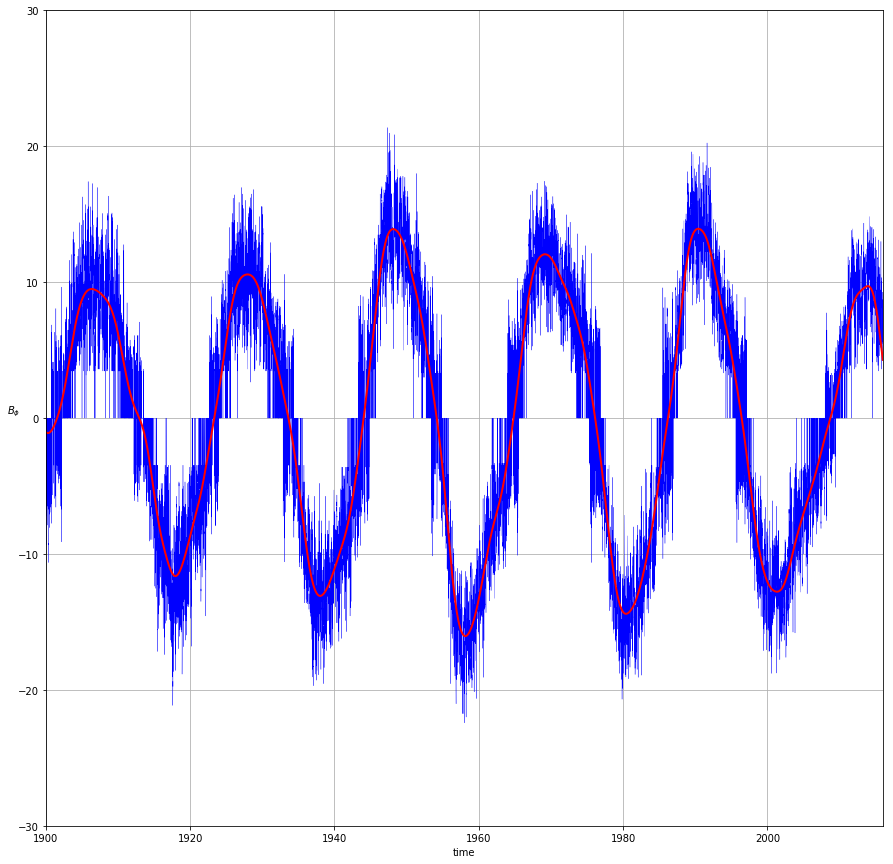

In [40]:
add_graph_parametrs()
plt.plot(changed_data_2[:,0], changed_data_2[:,1], linewidth=0.3, color='b')
plt.plot(smoothed_data_2[:,0], smoothed_data_2[:,1], linewidth=2, color='r')
plt.show()

## Сравнение с предыдущим

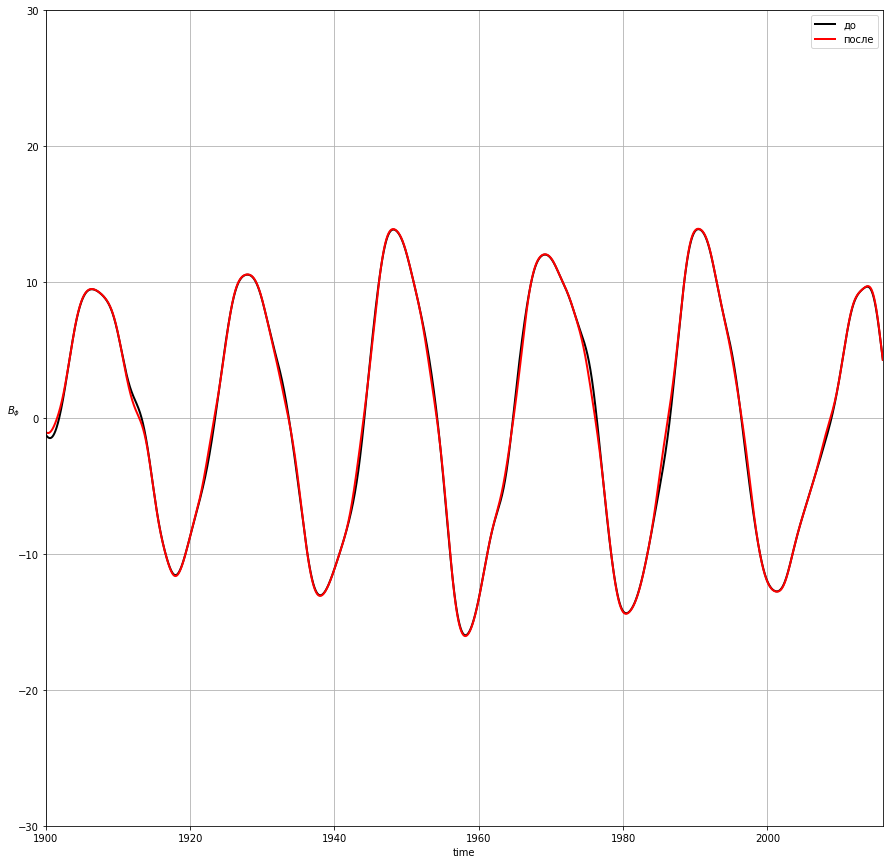

In [41]:
add_graph_parametrs()
plt.plot(smoothed_data[:,0], smoothed_data[:,1], linewidth=2, color='black', label='до')
plt.plot(smoothed_data_2[:,0], smoothed_data_2[:,1], linewidth=2, color='r', label='после')
plt.legend()
plt.show()

In [42]:
cycles_2 = get_cycles_borders(smoothed_data_2)

In [43]:
portraits_2 = []
for cycle in cycles_2:
    portraits_2.append(np.array(cycle_phase_portrait(cycle[0], cycle[1], smoothed_data_2)))

красный - без вероятности
 синий - с вероятностью



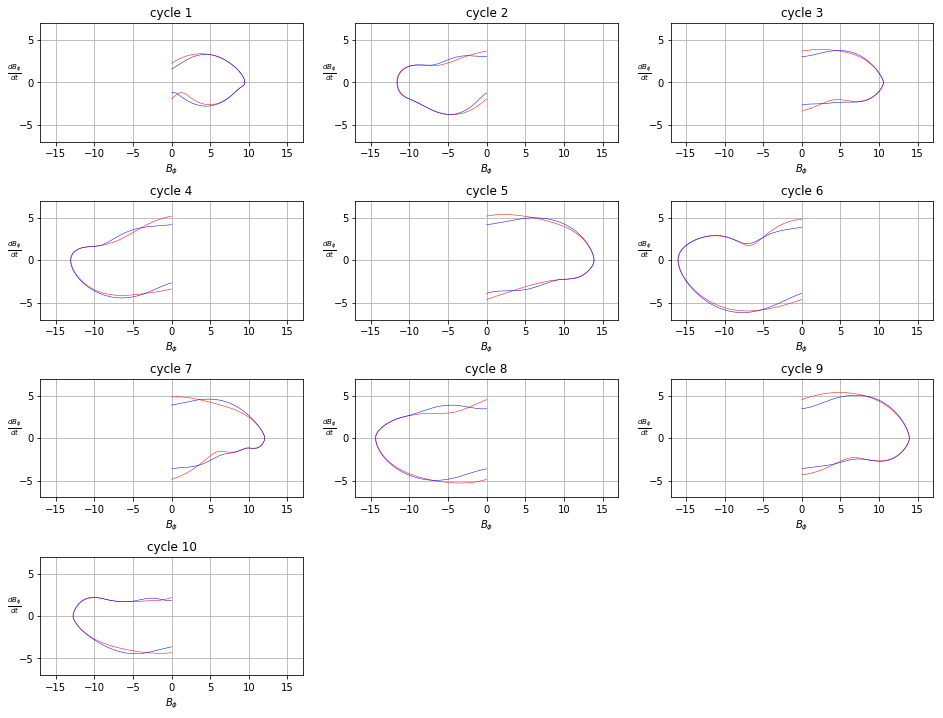

In [44]:
print('красный - без вероятности\n синий - с вероятностью\n')
draw_portraits(portraits, True, False, portraits_2)

In [45]:
write_cycles(portraits_2, cycles_2, "/home/viacheslav/progs/Sun2.0/integral_prob_approx/approxible_data.txt")
write_cycles(portraits_2, cycles_2, "/home/viacheslav/progs/Sun2.0/distance_prob_approx/approxible_data.txt")

In [46]:
all_parameters = []

## Получение приближения близкого по периоду с функцией ошибки равной среднему расстоянию для исходных данных

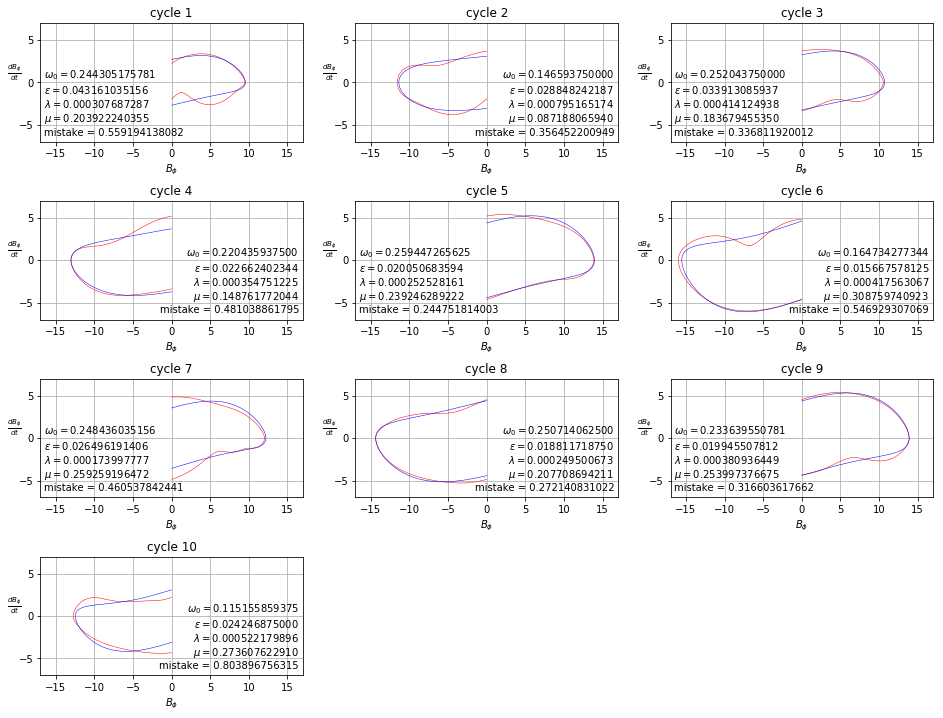

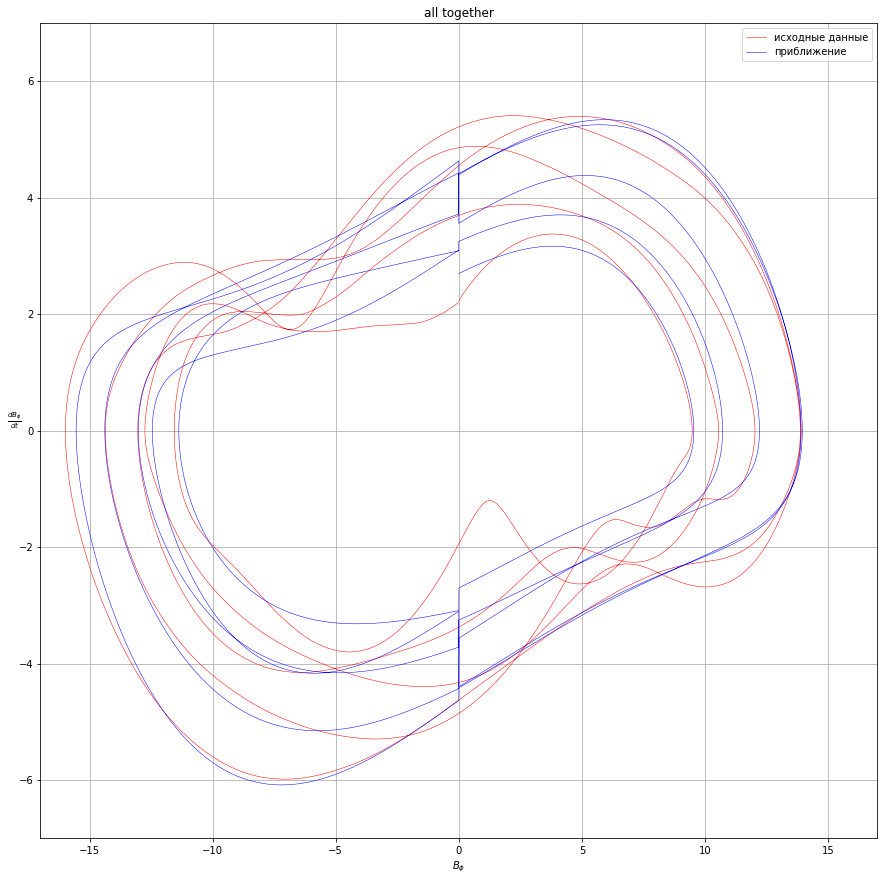

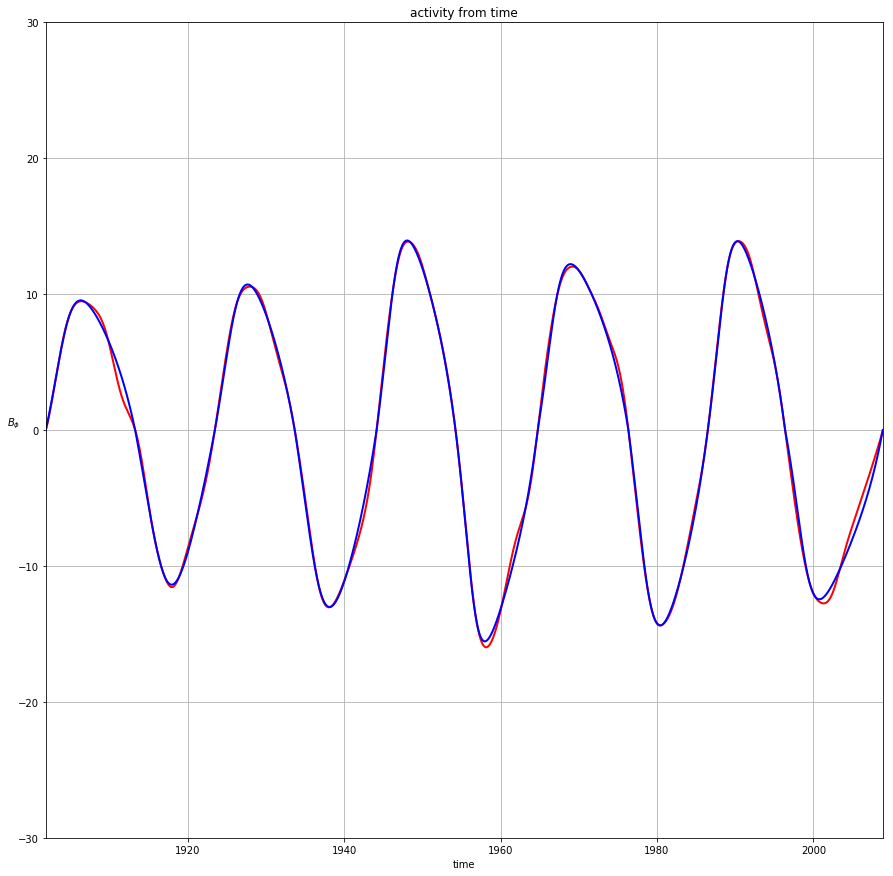

In [51]:
par = total_show('/home/viacheslav/progs/Sun2.0/distance_no_prob_approx', smoothed_data, portraits)
all_parameters.append(np.delete(par, (0), axis=1))

## Получение приближения близкого по периоду с функцией ошибки равной интегралу для исходных данных

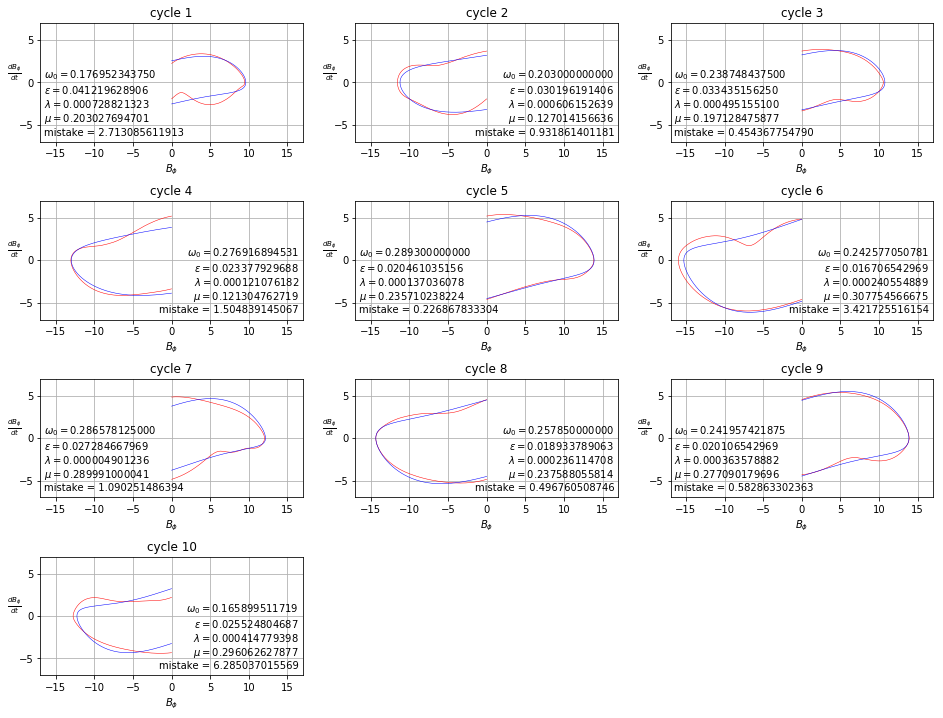

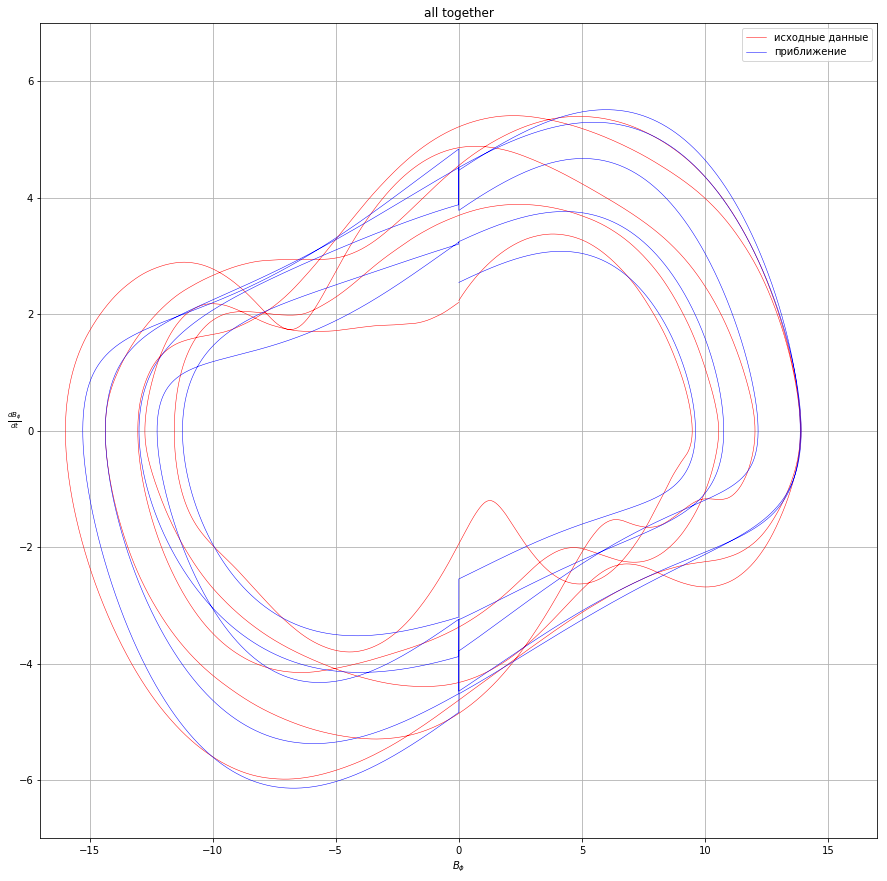

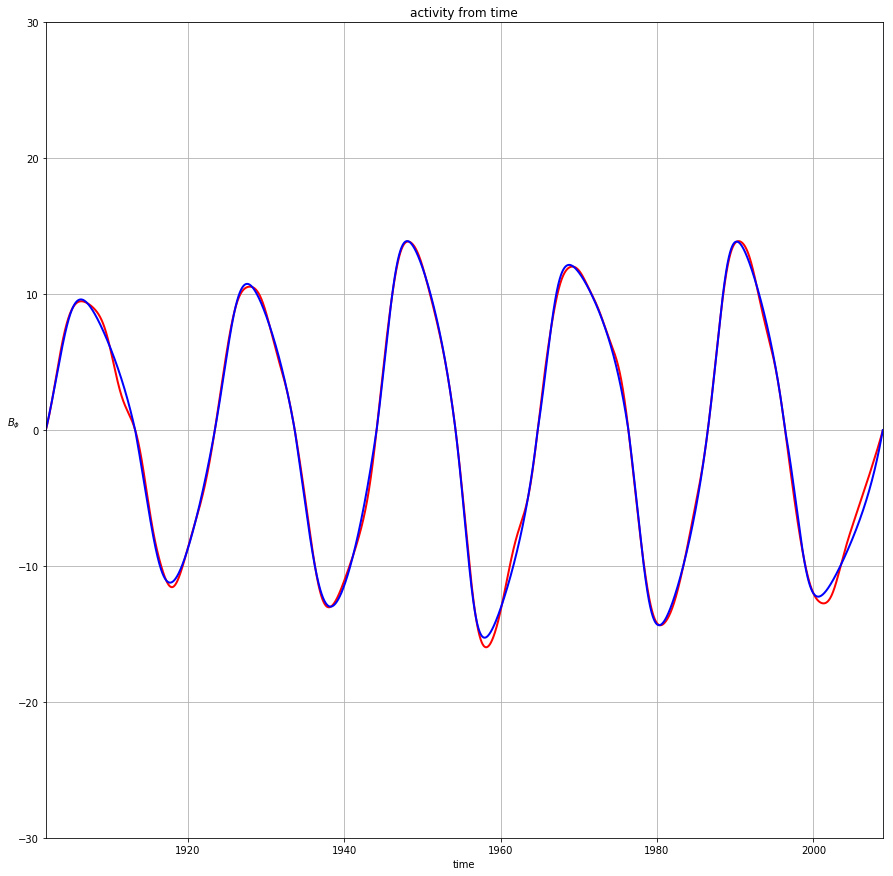

In [53]:
par = total_show('/home/viacheslav/progs/Sun2.0/integral_no_prob_approx', smoothed_data, portraits)
all_parameters.append(np.delete(par, (0), axis=1))

## Получение приближения близкого по периоду с функцией ошибки равной среднему расстоянию для 'новых' данных

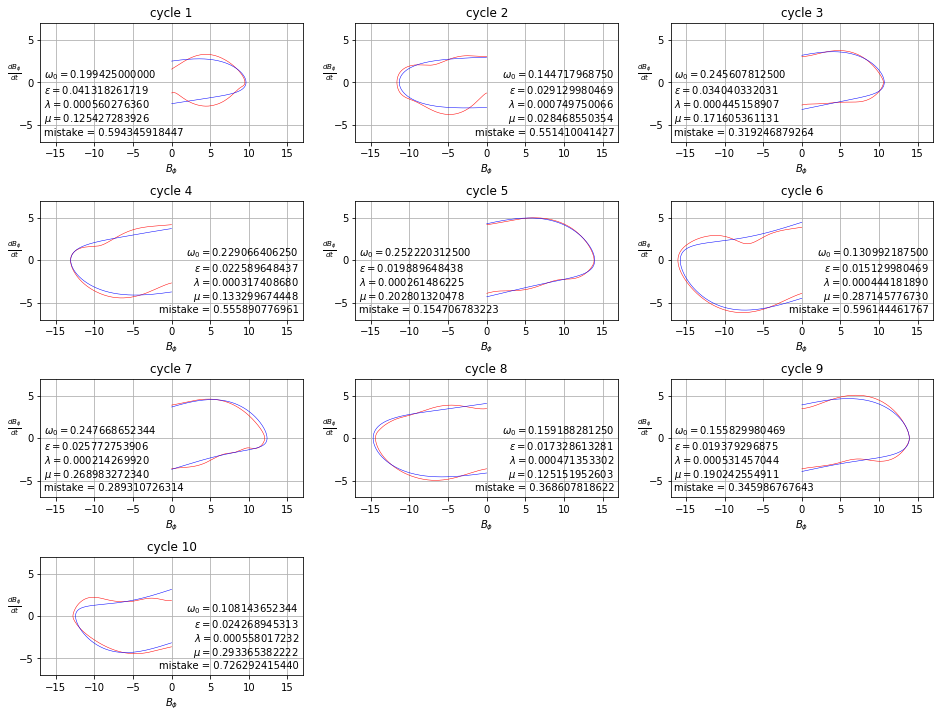

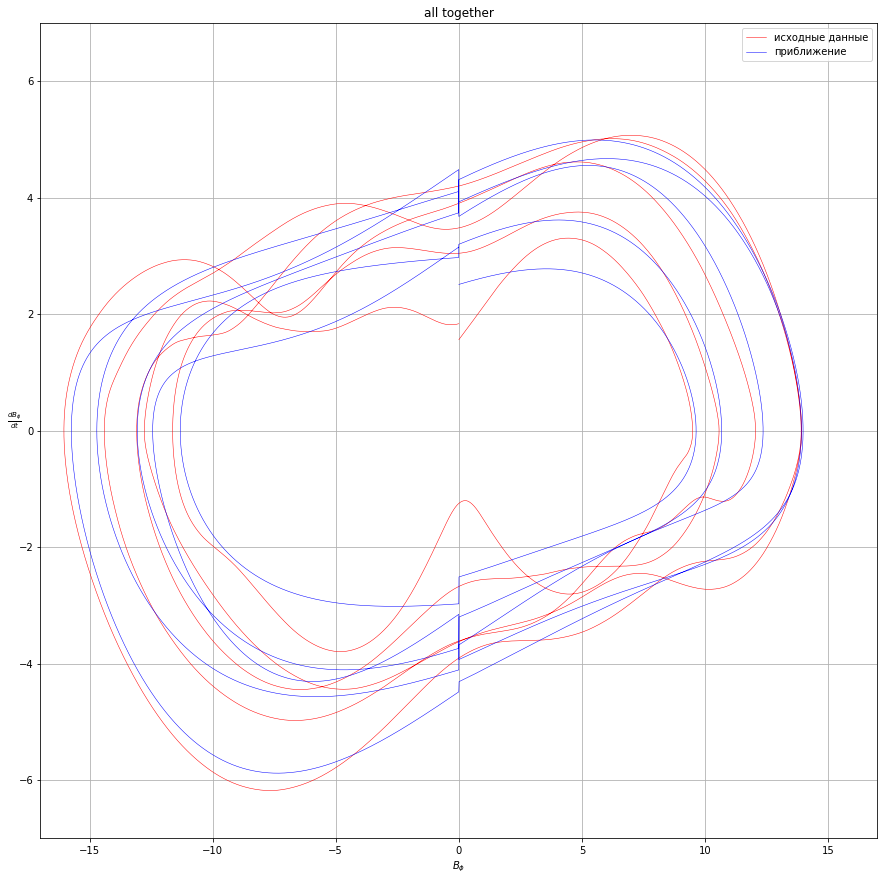

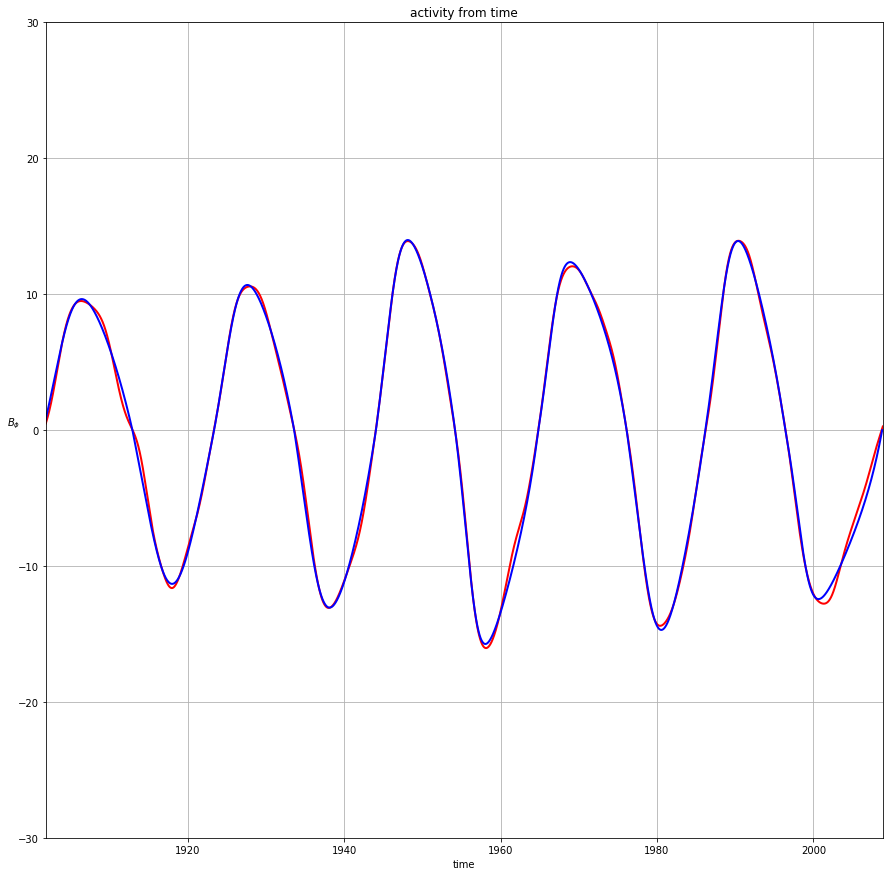

In [54]:
par = total_show('/home/viacheslav/progs/Sun2.0/distance_prob_approx', smoothed_data_2, portraits_2)
all_parameters.append(np.delete(par, (0), axis=1))

##  Получение приближения близкого по периоду с функцией ошибки равной интегралу для 'новых' данных

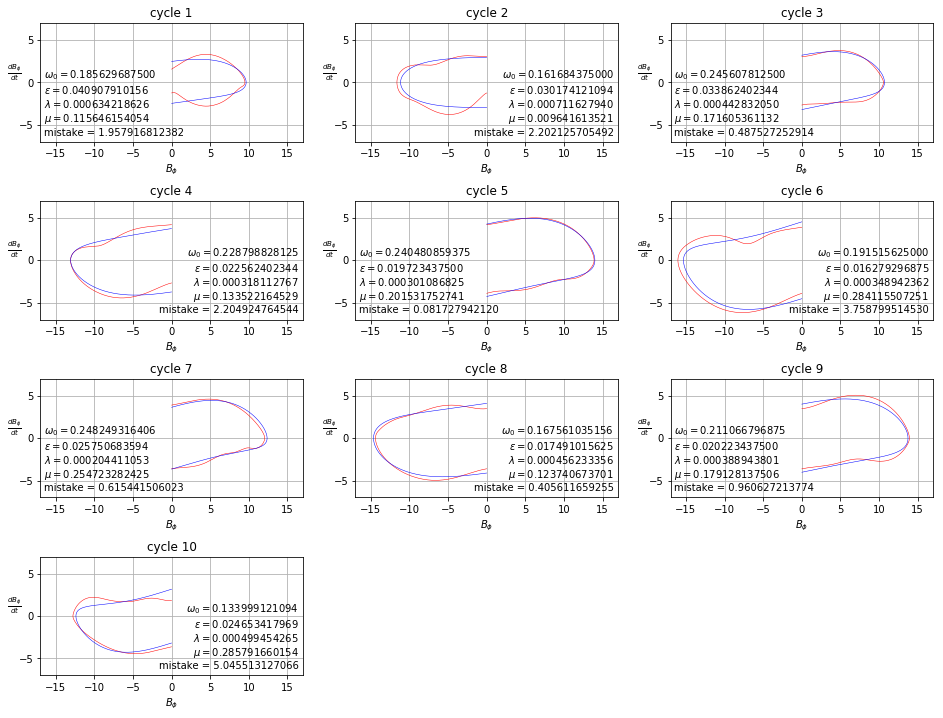

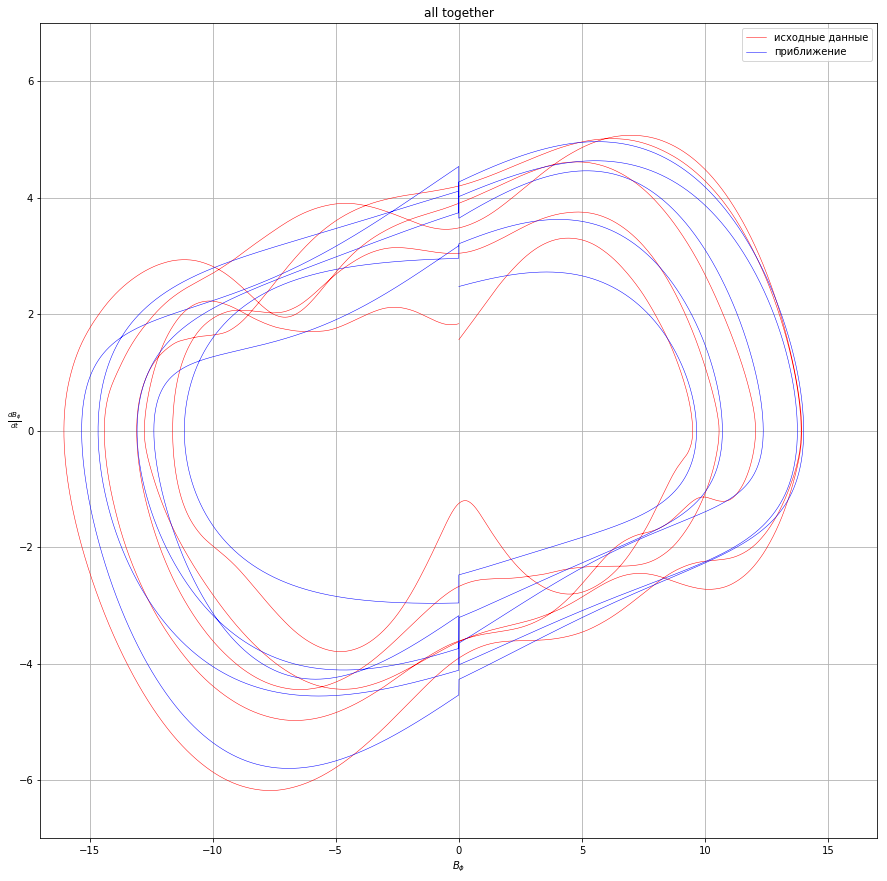

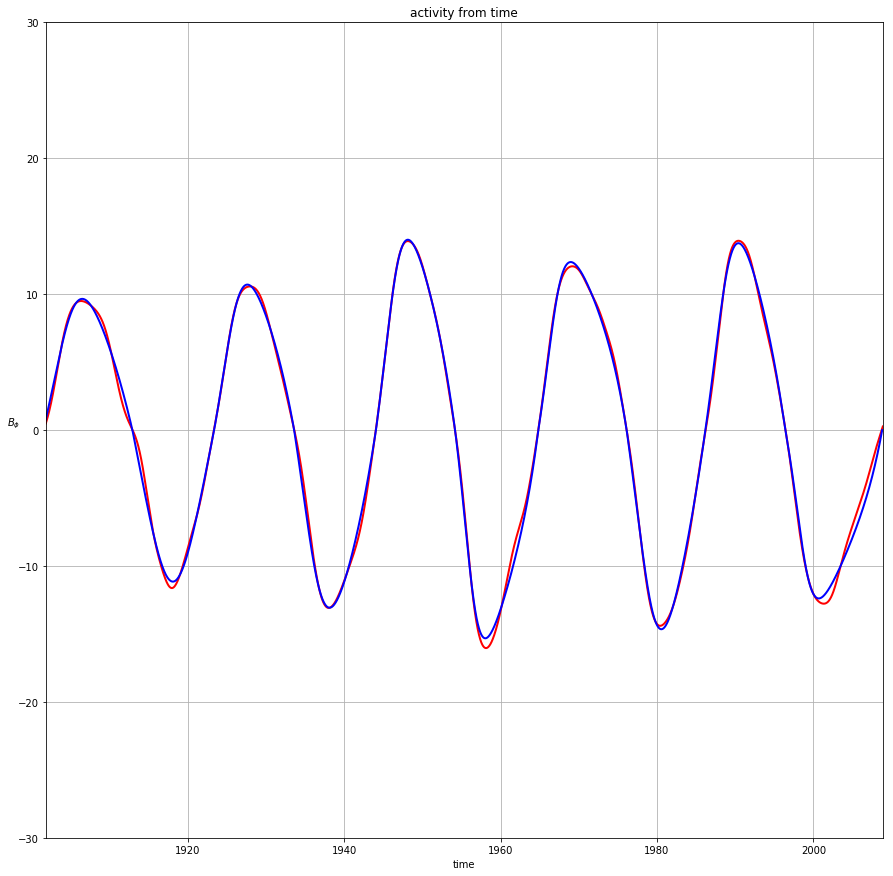

In [55]:
par = total_show('/home/viacheslav/progs/Sun2.0/integral_prob_approx', smoothed_data_2, portraits_2)
all_parameters.append(np.delete(par, (0), axis=1))

In [63]:
def add_extra_parameters(parameters):
    addmatrix = np.zeros((10, 4))
    for i in range(10):
        norm_lambda = parameters[i][2] / np.sqrt(parameters[i][1] * parameters[i][0] * parameters[i][0])
        norm_mu = parameters[i][3] / parameters[i][0]
        norm_A = parameters[i][4] * np.sqrt(parameters[i][1])
        norm_T = parameters[i][5] * parameters[i][0]
        addmatrix[i][0] = norm_lambda
        addmatrix[i][1] = norm_mu
        addmatrix[i][2] = norm_A
        addmatrix[i][3] = norm_T
    return np.concatenate([parameters, addmatrix], axis = 1)

In [64]:
file_names = ['distance_no_prob_correlation_table',
              'integral_no_prob_correlation_table',
              'distance_prob_correlation_table',
              'integral_prob_correlation_table']
parameter_names = ['omega', 'epsilon', 'lambda', 'mu', 'A', 'T',
                   'norm_lambda', 'norm_mu', 'norm_A', 'norm_T']

In [65]:
def create_correlation_table(number, parameters):
    f = open(file_names[number] + ".txt", "w")
    first_line = "{:<12}|".format("")
    for i in range(10):
        first_line += "{:^12}|".format(parameter_names[i])
    f.write(first_line + "\n")
    for i in range(10):
        f.write("{:^12}|".format(parameter_names[i]))
        for j in range(10):
            c = pearsonr(parameters[number][:,i], parameters[number][:,j])[0]
            f.write("{:^{width}.{prec}f}|".format(c, width=12, prec=6))
        f.write("\n")

In [66]:
def draw_parameters(number, parameters):
    plt.figure(figsize=(16, 12))
    plt.subplots_adjust(hspace=0.5)
    for i in range(10):
        ax = plt.subplot(4, 3, i + 1)
        ax.grid()
        ax.set_xlim([0, 11])
        ax.set_xlabel('cycle_number')
        ax.set_ylabel(parameter_names[i])
        ax.scatter(range(1, 11), parameters[number][:,i], color='b')
    plt.show()

## Таблицы коэффициентов корреляций для всех моделей и визуылизация параметров

In [67]:
full_all_parameters = []
for i in range(4):
    full_all_parameters.append(add_extra_parameters(all_parameters[i]))
    create_correlation_table(i, full_all_parameters)

## Визуализация коэффициентов в модели без вероятностного сглаживания с и функцией ошибки равной среднему расстоянию

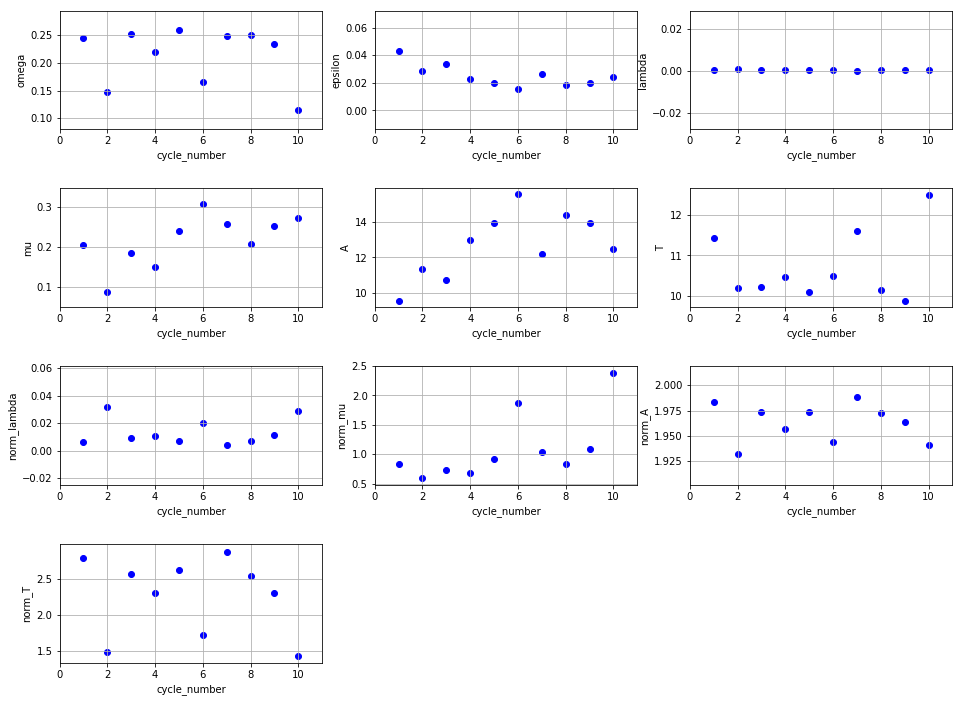

In [69]:
draw_parameters(0, full_all_parameters)

## Визуализация коэффициентов в модели без вероятностного сглаживания с и интегральной функцией ошибки

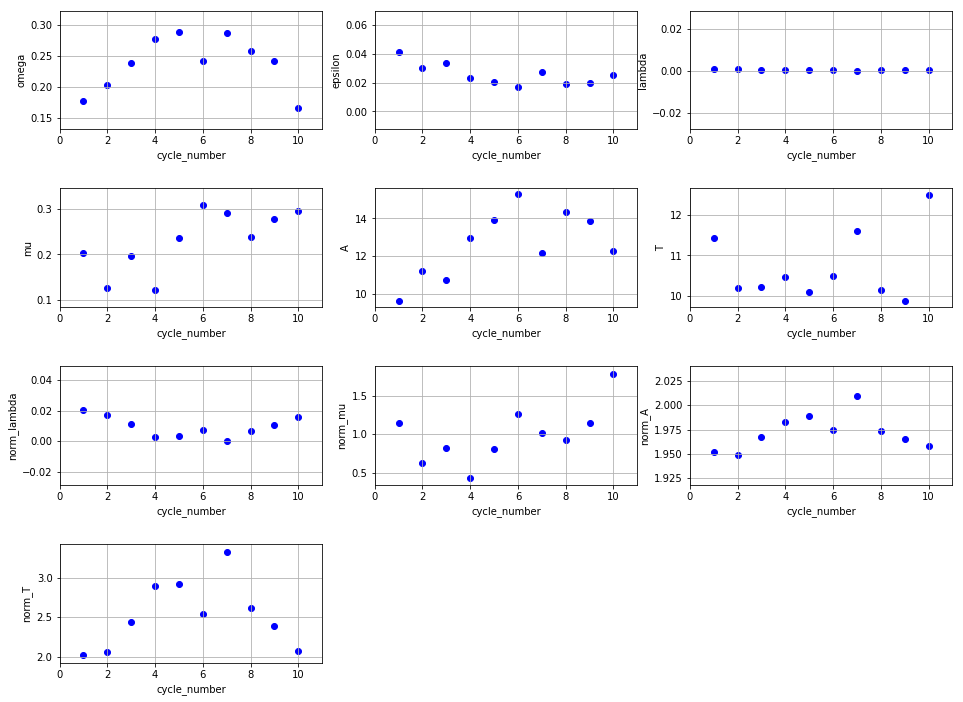

In [70]:
draw_parameters(1, full_all_parameters)

## Визуализация коэффициентов в модели c вероятностным сглаживанием и функцией ошибки равной среднему расстоянию

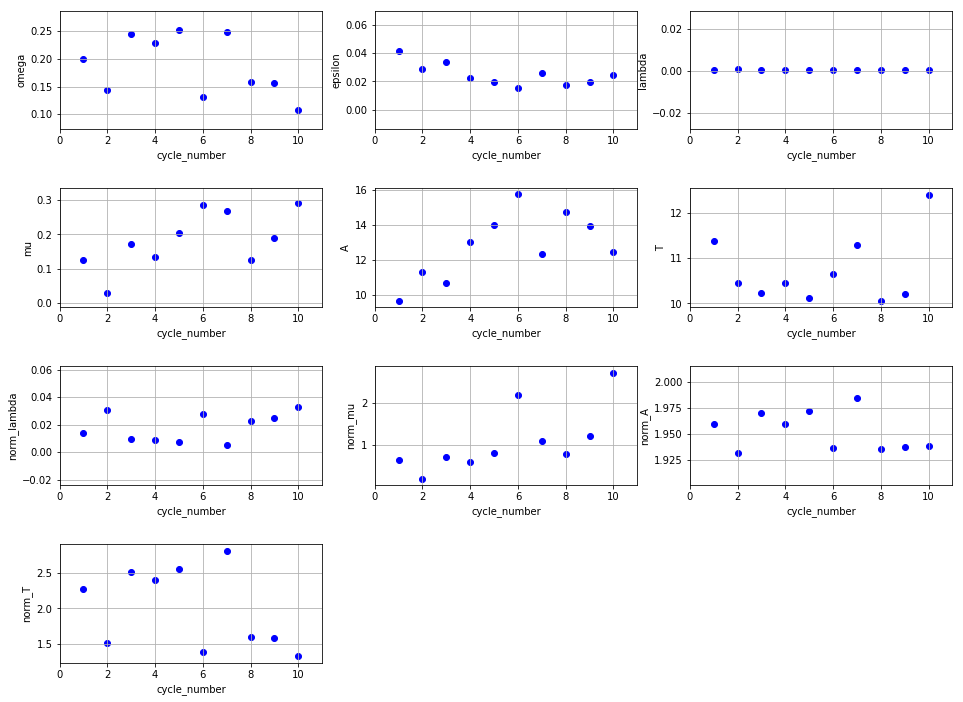

In [71]:
draw_parameters(2, full_all_parameters)

## Визуализация коэффициентов в модели c вероятностным сглаживанием с итегральной функцией ошибки 

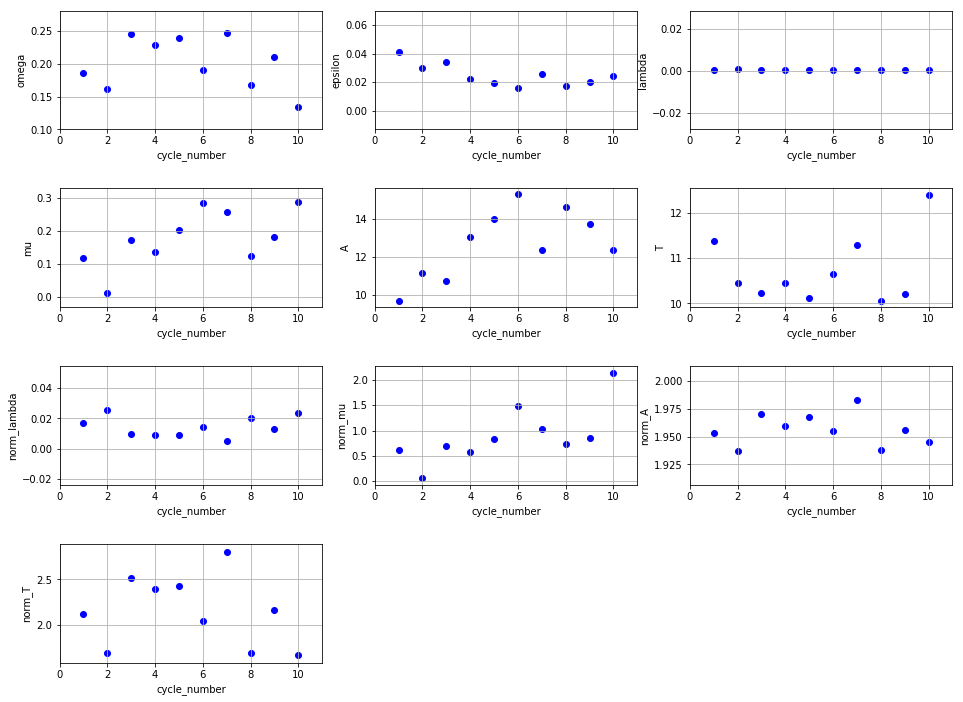

In [72]:
draw_parameters(3, full_all_parameters)

Примечание: 

1) lambda лишь кажется мало меняющимся параметром так как вносит большой вклад (ибо стоит при кубе x с большой A) имеет смысл смотреть на norm_lambda.

2) В файлах distance_no_prob_correlation_table.txt, integral_no_prob_correlation_table.txt, distance_prob_correlation_table.txt, integral_prob_correlation_table.txt находятся таблицы корреляций параметров(в самой удобной форме которую смог придумать)

3) единственное, чо похоже на медленно меняющийся параметр - epsilon но пока не ясно как это поможет